In [1]:
# we are importing Kmeans package from scikit-learn 
# to divide the dataset in clusters
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10

#no of clusters
M = 10
PHI = []

IsSynthetic = False

In [3]:
# Iterates the file and returns list of target vectors
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# Iterate the file, remove unimportant features and returns the transposed matrix
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    # if this Flag is set to false, we are deleting the features with no values, 
    # as they do not add anything to the model as it has no co-variance.
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    
    dataMatrix = np.transpose(dataMatrix) 
    
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]


    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j]) 
        
        # we are calculating the variance of a feature over all the datapoints
        varVect.append(np.var(vct))
    
     
    for j in range(len(Data)):
        
        # creating big Sigma which is a diagonal matrix consists of 
        #feature variance with a dimention of 41x41
        
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        
        # We are scaling the bigSigma value. It is a hyper parameter, which can tweaked according 
        # to the problem at hand
        
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# implementation of the formula of design matrix
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# returns the value of design matrix
# Each row in training dataset is getting evaluated against the mean
# of each cluster. for example, if we divide the dataset in 10 clusters,
# elements of design matrix will be returned, which is generated by computation
# with each of centroid and all of training data.
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))   

    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):            
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#Generating weights by weights by transposing design matrix and doing dot product with itself,
# adding it to the Lambda hyperparameter, then multiplying it with the transpose of design matrix
# and traing data after inversing it.
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

# returns the output of model which we can compare to target values
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# returns the Root-mean-square error

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [4]:
#loading the target dataset. in this datastucture 0 represents least relevent and 2 represents most relevent.
RawTarget = GetTargetVector('Querylevelnorm_t.csv')

# loading the dataset on which we will train, test and validate the model.
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'U' mode is deprecated
  


## Prepare Training Data

In [5]:
# spliting the target data for training to map with training results.
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))

#Spliting 80% of data to train the model
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [6]:
#Spliting 10% of data to validating and correcting the accuracy of the model
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

(6962,)
(41, 6962)


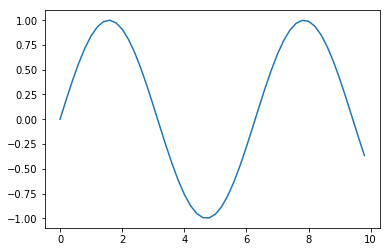

In [7]:
#Slicing 10% of the data to check the model accuracy. 
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

x = np.arange(0, 10, 0.2)
y = np.sin(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
plt.show()

## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

inside 0
73.92233253738846,0.5494694067137861
inside 1
73.92233253738846,0.5494694067137861
inside 2
73.92233253738846,0.5494694067137861
inside 3
73.92233253738846,0.5494694067137861
inside 4
73.92233253738846,0.5494694067137861
inside 5
73.92233253738846,0.5494694067137861


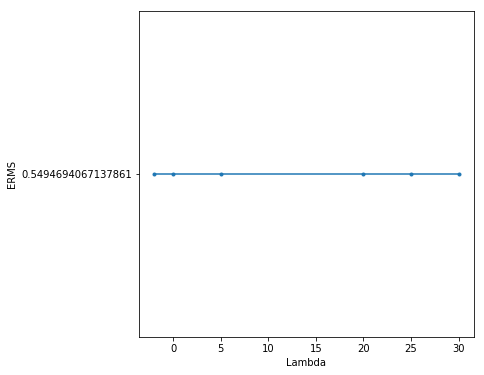

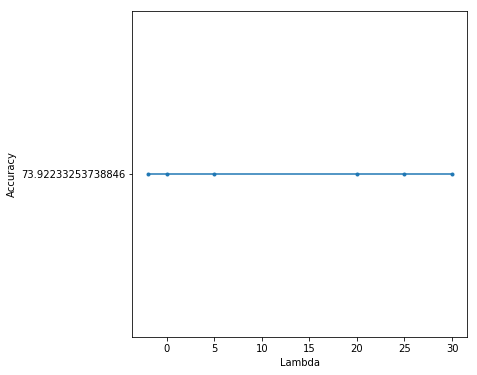

UBITname      = amlangup
Person Number = 50288686
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5494694067137861
E_rms Validation = 0.5384281741389029
E_rms Testing    = 0.6279788453856765


In [13]:
ErmsArr = []
AccuracyArr = []


#things to change
# clusters, lambda, learning rate.
cluster_array = [1,10, 15, 30]
lambda_array = [-2, 0.03, 5, 20, 25, 30]

for i in range(6):
    print('inside '+ str(i))

    # we are dividing the dataset in multiple clustors
    # and we are not giving any intial value to the centroid
    # then we are feeding the training dataset without any sample weight

    #kmeans = KMeans(n_clusters=cluster_array[i], random_state=0).fit(np.transpose(TrainingData))
    kmeans = KMeans(n_clusters=10, random_state=0).fit(np.transpose(TrainingData))

    # cluster_centers_ returns the mean of clusters. The Mu here is a matrix of 10x41 (10 clusters, 41 features)

    Mu = kmeans.cluster_centers_

    #TODO: wat is big sigma
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)

    # generating design matrix for training data
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)

    # Weights for computing with design matrix is getting generated here. 
    # Lambda is a hyperparameter we have set to reduces the spikes in weight.
    # If an weight's value is significantly higher than others, features associates with
    # it gets much higher priority, as a result, it dominates the other features' importance,
    # which may cause overfitting.
    W = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda))
    #W = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(lambda_array[i])) 

    # Generating Design matrix for Testing data
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 

    #Generating design matrix on validation data
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

    # getting the output on training, validation and testing dataset.

    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    # Calculating Root-mean-square error for 3 sets

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
    ErmsArr.append(str(float(TrainingAccuracy.split(',')[1])))
    AccuracyArr.append(str(float(TrainingAccuracy.split(',')[0])))
    print(str(TrainingAccuracy))




plt.figure(figsize=[6, 6])
plt.plot(lambda_array, ErmsArr, marker='.')
plt.xlabel('Lambda')
plt.ylabel('ERMS')
plt.show()

plt.figure(figsize=[6, 6])
plt.plot(lambda_array, AccuracyArr, marker='.')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.show()


print ('UBITname      = amlangup')
print ('Person Number = 50288686')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))



In [9]:
# print(Mu.shape)
# print(BigSigma.shape)
# print(TRAINING_PHI.shape)
# print(W.shape)
# print(VAL_PHI.shape)
# print(TEST_PHI.shape)

## Finding Erms on training, validation and test set 

## Gradient Descent solution for Linear Regression

In [10]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [11]:
# We are setting the optimized weight with a variation as initial weight.

W_Now        = np.dot(220, W) 

La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

erms_array_tr = []
erms_array_val = []
learning_rate_array = [0.01, 0.5, 3, 5]
for lr in range(4):
    # We are going to ananlyze only a small number of data, as the weights 
    # are close to optimized, and there are not much room for improvement, 
    # so analying whole training set is redundant.
    for i in range(0,50):
        print(str(i))

        # We are implementing Stochastic

        #print ('---------Iteration: ' + str(i) + '--------------')

        # here we are calculating the weight changes we have to get a more optimized solution
        # for that we have to calculate the error changes first and combining with learning rate
        # we decide what will be the new weights for next iteration.

        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learning_rate_array[lr],Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next


        # We are printing out Traing, Validatin and testing data on the fly during iteration.
        # In a real world scenario, training a model could take multiple days,
        # so it's the norm to printing out changes during the iteration as they can
        # monitored in real time

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
        
        
    print ('----------Gradient Descent Solution--------------------')
    print ("M = 15 \nLambda  = 0.0001\neta=0.01")
    print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    
    
    erms_array_tr.append(np.around(min(L_Erms_TR),5))
    erms_array_val.append(np.around(min(L_Erms_Val),5))
    
    
plt.figure(figsize=[4, 4])
plt.plot(learning_rate_array, erms_array_tr, marker='.')
plt.xlabel('Learning Rate')
plt.ylabel('Training ERMS')
plt.show()

plt.figure(figsize=[4, 4])
plt.plot(learning_rate_array, erms_array_val, marker='.')
plt.xlabel('Learning Rate')
plt.ylabel('Validation ERMS')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 10.40914
E_rms Validation = 10.07238
E_rms Testing    = 10.3175
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 10.40914
E_rms Validation = 10.07238
E_rms Testing    = 10.3175
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 10.40914
E_rms Validation = 10.07238
E_rms Testing    = 10.3175
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23

OverflowError: math range error